# Locating Nearest Facility with Origin-Destination Matrix


## Overview 

This tutorial is based on [Locating Nearest Facility with Origin-Destination Matrix (QGIS3)](https://www.qgistutorials.com/en/docs/3/origin_destination_matrix.html).

We will take 2 layers for Washington DC - one with points representing addresses and another with points representing mental health facilities - and find out the facility with the least travel distance from each address using the [OpenRouteService (ORS) Distance Matrix API](https://openrouteservice.org/dev/#/api-docs/v2/matrix).

Input Layers:

* `Address_Points.zip`: A shapefile with locations of randomly selected 100 addresses.
* `Adult_Mental_Health_Providers.zip`: A shapefile with  locations of Adult Mental Health Providers

Output:
* `matrix.xlsx`: An excel sheet containing the nearest health facility for each address.

Data Credit: District of Columbia [Open Data Catalog](https://opendata.dc.gov/). Accessed: August 2019

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev -qq
    !pip install fiona shapely pyproj rtree --quiet
    !pip install geopandas --quiet
    !pip install contextily

In [2]:
import os
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx


In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'Address_Points.zip')
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'Adult_Mental_Health_Providers.zip')

Visit [OpenRouteService Sign-up page](https://openrouteservice.org/dev/#/signup) and create an account. Once your account is activated, visit your Dashboard and request a token. Select `Standard` as the Token type and enter `python` as the Token name. Click *CREATE TOKEN*. Once created, copy the long string displayed under Key and enter below.

In [15]:
ORS_API_KEY = 'replace this with your key'
ORS_API_KEY = '5b3ce3597851110001cf6248211fcc113a28495ebc487cda6358e7f2'


## Procedure

Read the `Adult_Mental_Health_Providers.zip` file and convert it to a GeoDataFrame.

In [6]:
health_shp = 'Adult_Mental_Health_Providers.zip'
health_shp_path = os.path.join(data_folder, health_shp)
health_gdf = gpd.read_file(health_shp_path) 
health_gdf

,OBJECTID,NAME,XCOORD,YCOORD,ADDRESS_ID,ADDRESS,geometry
0,1,Anchor Mental Health,400686.38,140381.22,289589,1001 LAWRENCE STREET NE,POINT (-76.99209 38.93132)
1,2,"Capital Community Services, LLC",400882.92,133122.47,278056,2041 MARTIN LUTHER KING JR AVENUE SE,POINT (-76.98983 38.86593)
2,3,CPEP,402284.84,134922.1,303596,1905 E STREET SE,POINT (-76.97367 38.88214)
3,4,Deaf-Reach,400800.33,140588.61,33726,3521 12TH STREET NE,POINT (-76.99077 38.93319)
4,5,Green Door,397593,141469.99,225296,1221 TAYLOR STREET NW,POINT (-77.02777 38.94112)
5,6,McClendon Center,397292.44,136903.07,279043,1313 NEW YORK AVENUE NW,POINT (-77.03122 38.89998)
6,7,McClendon Center,399186.75,137839.02,236989,1338 NORTH CAPITOL STREET NW,POINT (-77.00938 38.90842)
7,8,Neighbors Consejo,396806.73,140159.22,236410,3118 16TH STREET NW,POINT (-77.03683 38.92931)
8,9,Pathways To Housing,399464.96,138105.77,75978,101 Q STREET NE,POINT (-77.00617 38.91082)
9,10,Psychiatric Center Chartered,403447.95,140054.18,287351,3001 BLADENSBURG ROAD NE,POINT (-76.96024 38.92837)


Read the `Address_Points.zip` file and convert it to a GeoDataFrame.

In [7]:
address_shp = 'Address_Points.zip'
adddress_shp_path = os.path.join(data_folder, address_shp)
address_gdf = gpd.read_file(adddress_shp_path) 
address_gdf

,OBJECTID_1,OBJECTID,SITE_ADDRE,ADDRESS_ID,ROADWAYSEG,STATUS,SSL,TYPE_,ENTRANCETY,ADDRNUM,...,ACTIVE_RES,RES_TYPE,ACTIVE_R_1,WARD_2002,WARD_2012,ANC_2002,ANC_2012,SMD_2002,SMD_2012,geometry
0,832136,3396.0,50921,50921,10460.0,ACTIVE,0757 0849,ADDRESS,OFFICIAL,217.0,...,0,RESIDENTIAL,1,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C08,SMD 6C02,POINT (-77.00281 38.89344)
1,832838,625.0,15061,15061,177.0,ACTIVE,1043 0863,ADDRESS,OFFICIAL,502.0,...,0,RESIDENTIAL,1,Ward 6,Ward 6,ANC 6B,ANC 6B,SMD 6B06,SMD 6B06,POINT (-76.98806 38.88265)
2,835000,1295.0,12265,12265,12996.0,ACTIVE,0834 0080,ADDRESS,OFFICIAL,516.0,...,0,RESIDENTIAL,1,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C05,SMD 6C05,POINT (-76.99886 38.89753)
3,835839,6690.0,145709,145709,9398.0,ACTIVE,0871 0033,ADDRESS,OFFICIAL,634.0,...,9,RESIDENTIAL,9,Ward 6,Ward 6,ANC 6B,ANC 6B,SMD 6B02,SMD 6B02,POINT (-76.99727 38.88729)
4,837003,8487.0,226389,226389,10939.0,ACTIVE,2853 0204,ADDRESS,OFFICIAL,1117.0,...,2,RESIDENTIAL,2,Ward 1,Ward 1,ANC 1A,ANC 1A,SMD 1A11,SMD 1A11,POINT (-77.02804 38.92692)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,970868,60564.0,231545,231545,13092.0,ACTIVE,2853 0860,ADDRESS,OFFICIAL,2900.0,...,2,RESIDENTIAL,2,Ward 1,Ward 1,ANC 1A,ANC 1A,SMD 1A11,SMD 1A11,POINT (-77.02733 38.92686)
96,972246,13039.0,260313,260313,15025.0,ACTIVE,2335 0117,ADDRESS,OFFICIAL,6136.0,...,0,RESIDENTIAL,1,Ward 4,Ward 4,ANC 3G,ANC 3G,SMD 3G02,SMD 3G02,POINT (-77.06086 38.97097)
97,975435,79362.0,238210,238210,12222.0,ACTIVE,0552 0218,ADDRESS,OFFICIAL,120.0,...,2,RESIDENTIAL,2,Ward 5,Ward 5,ANC 5C,ANC 5E,SMD 5C01,SMD 5E05,POINT (-77.01294 38.91023)
98,997791,NaN,314564,314564,40238.0,ACTIVE,3765 0005,ADDRESS,OFFICIAL,455.0,...,0,NON RESIDENTIAL,0,Ward 5,Ward 5,ANC 5A,ANC 5A,SMD 5A02,SMD 5A08,POINT (-76.99921 38.95365)


Let's visualize the locations.

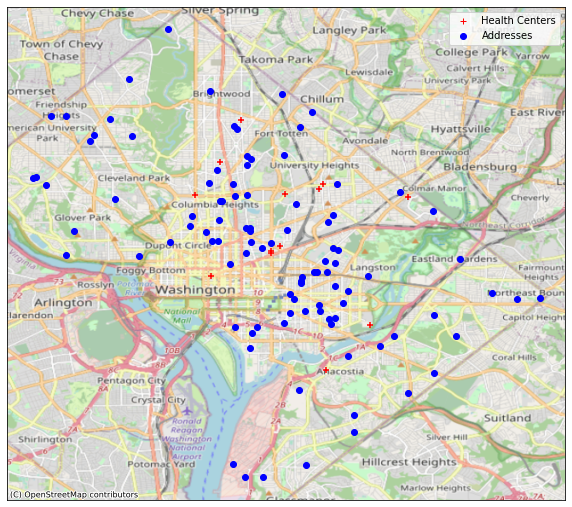

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
health_gdf.plot(ax=ax, color='red', alpha=1, marker='+')
address_gdf.plot(ax=ax, color='blue', alpha=1, marker='o')
cx.add_basemap(ax, crs=health_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

legend_elements = [
    plt.plot([],[], color='red', alpha=1, marker='+', label='Health Centers', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Addresses', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

THe ORS Distance Matrix API needs a list of locations in the (longitude,latitude) format. We take the geometry column from the GeoDataFrame and create the list.

In [16]:
origins = list(zip(address_gdf.geometry.x, address_gdf.geometry.y))
destinations = list(zip(health_gdf.geometry.x, health_gdf.geometry.y))

In [17]:
locations = origins + destinations

Another parameter required by the API are the list of indices for origins and destinations. If you want the distances between each location, you can specify `all` instead of the list of indices.

In [18]:
origins_index = list(range(0, len(origins)))
destinations_index = list(range(len(origins), len(locations)))

In [19]:
body = {'locations': locations,
       'destinations': destinations_index,
       'sources': origins_index,
       'metrics': ['distance']}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': ORS_API_KEY,
    'Content-Type': 'application/json; charset=utf-8'
}

response = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)


In [21]:
distances = response.json()['distances']

In [25]:
distance_matrix = []
for origin_index, item  in address_gdf.iterrows():
  origin_name = item['OBJECTID_1']
  origin_x = item.geometry.x
  origin_y = item.geometry.y
  origin_distances = distances[origin_index]
  # We find the minimum distance and the index of the minimum distance
  min_distance = min(origin_distances)
  min_index = origin_distances.index(min_distance)
  destination_index = destinations_index[min_index]
  destination_x, destination_y = locations[destination_index]
  filtered = health_gdf[(health_gdf.geometry.x == destination_x) & (health_gdf.geometry.y == destination_y) ]
  destination_row = filtered.iloc[0]
  destination_name = destination_row['NAME']

  distance_matrix.append(
    [origin_name, origin_y, origin_x, destination_name, destination_y, destination_x, min_distance])

In [26]:
df = pd.DataFrame(distance_matrix, 
                  columns =['origin', 'origin_y', 'origin_x', 'destination', 'destination_y', 'destination_x', 'distance'])
df

,origin,origin_y,origin_x,destination,destination_y,destination_x,distance
0,832136,38.893438,-77.002814,Pathways To Housing,38.910822,-77.006171,2605.23
1,832838,38.882648,-76.988059,CPEP,38.882139,-76.973669,1822.86
2,835000,38.897525,-76.998862,Pathways To Housing,38.910822,-77.006171,2115.34
3,835839,38.887289,-76.997275,CPEP,38.882139,-76.973669,2429.71
4,837003,38.926925,-77.028035,Neighbors Consejo,38.929314,-77.036830,1140.59
...,...,...,...,...,...,...,...
95,970868,38.926861,-77.027326,Neighbors Consejo,38.929314,-77.036830,1126.98
96,972246,38.970969,-77.060863,Volunteers of America Chesapeake,38.956164,-77.020380,5323.17
97,975435,38.910229,-77.012939,Woodley House Inc.,38.908954,-77.009409,615.14
98,997791,38.953646,-76.999206,Volunteers of America Chesapeake,38.956164,-77.020380,2244.39
